In [1]:
import pandas as pd
import pickle
import numpy as np
from keras.layers import Flatten, Embedding, Input, concatenate, Dense, Dropout
from keras.models import Model
import matplotlib.pyplot as plt, operator, random, pickle
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [2]:
PATH='dataset/rossmann/'

In [3]:
joined = pd.read_feather(f'{PATH}joined.feather')
joined_test = pd.read_feather(f'{PATH}joined_test.feather')

In [4]:
joined.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0.0,0.0,0.0,0.0,0.0
Promo_bw,5.0,5.0,5.0,5.0,5.0
SchoolHoliday_fw,7.0,1.0,5.0,1.0,1.0
StateHoliday_fw,0.0,0.0,0.0,0.0,0.0


In [5]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [6]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

In [7]:
# mean/max wind; min temp; cloud; min/mean humid; 
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [8]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

In [9]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [10]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [11]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

16

In [12]:
cat_map_fit.transform(joined)[0,:5], contin_map_fit.transform(joined)[0,:5]

(array([ 0, 30,  4,  6,  4]),
 array([-0.53483095,  1.00811273,  0.80697768,  0.31785622,  0.61424134]))

In [13]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

In [14]:
[len(o[1].classes_) for o in cat_map_fit.features]

[1115, 31, 7, 12, 12, 23, 8, 22, 2, 3, 4, 3, 25, 4, 52, 26, 6, 6, 3, 3, 8, 8]

In [15]:
joined_sales = joined[joined.Sales!=0]
n = len(joined_sales)
n

844338

In [16]:
samp_size = 100000
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [17]:
joined_samp = joined_sales.iloc[idxs].set_index("Date")
samp_size = n
joined_samp = joined_sales.set_index("Date")

In [18]:
train_ratio = 0.9
train_size = int(samp_size * train_ratio)

In [19]:
train_size

759904

In [20]:
joined_valid = joined_samp[train_size:]
joined_train = joined_samp[:train_size]
len(joined_valid), len(joined_train)

(84434, 759904)

In [21]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

In [22]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)

In [23]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [24]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

In [25]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

In [26]:
max_log_y = np.max(np.log(joined_samp.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

In [27]:
def rmspe(y_pred, targ = y_valid_orig):
    pct_var = (targ - y_pred)/targ
    return math.sqrt(np.square(pct_var).mean())

def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

# - This can be used if ymean and ystd are calculated above (they are currently commented out)
def normalize_inv(preds):
    return preds * ystd + ymean

Create models

In [28]:
def split_cols(arr):
    return np.hsplit(arr,arr.shape[1])

In [29]:
# - This gives the correct list length for the model
# - (list of 23 elements: 22 embeddings + 1 array of 16-dim elements)  
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [30]:
len(map_train)

23

In [31]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [32]:
cat_map_info(cat_map_fit.features[1])

('Day', 31)

In [33]:
# - In Keras 2 the "initializations" module is not available.
# - To keep here the custom initializer the code from Keras 1 "uniform" initializer is exploited 
def my_init(scale):
#     return lambda shape, name=None: initializations.uniform(shape, scale=scale, name=name)
    return K.variable(np.random.uniform(low=-scale, high=scale, size=shape),
                      name=name)

In [34]:
# - In Keras 2 the "initializations" module is not available.
# - To keep here the custom initializer the code from Keras 1 "uniform" initializer is exploited 
def emb_init(shape, name=None): 
#     return initializations.uniform(shape, scale=2/(shape[1]+1), name=name)
    return K.variable(np.random.uniform(low=-2/(shape[1]+1), high=2/(shape[1]+1), size=shape),
                      name=name)

In [35]:
# def get_emb(feat):
#     name, c = cat_map_info(feat)
#     #c2 = cat_var_dict[name]
#     c2 = (c+1)//2
#     if c2>50: c2=50
#     inp = Input((1,), dtype='int64', name=name+'_in')
#     # , kernel_regularizer=l2(1e-6)  # Keras 2
#     u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, embeddings_initializer=emb_init)(inp))  # Keras 2
# #     u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
#     return inp,u

def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    return inp, u

In [36]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', kernel_initializer=my_init(1.))(inp)  # Keras 2

In [37]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)
#contin_out = BatchNormalization()(contin_out)

In [38]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
#conts = [get_contin(feat) for feat in contin_map_fit.features]
#contin_d = [d for inp,d in conts]
x = concatenate([emb for inp,emb in embs] + [contin_out])  # Keras 2
#x = concatenate([emb for inp,emb in embs] + contin_d)  # Keras 2

x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', kernel_initializer='uniform')(x)
x = Dense(500, activation='relu', kernel_initializer='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
#model = Model([inp for inp,emb in embs] + [inp for inp,d in conts], x)
model.compile('adam', 'mean_absolute_error')
#model.compile(Adam(), 'mse')

In [39]:
hist = model.fit(map_train, y_train, batch_size=1024, epochs=5,
                 verbose=1, validation_data=(map_valid, y_valid))

Epoch 1/5
743/743 [==============================] - 45s 57ms/step - loss: 0.0155 - val_loss: 0.0120
Epoch 2/5
743/743 [==============================] - 38s 51ms/step - loss: 0.0100 - val_loss: 0.0112
Epoch 3/5
743/743 [==============================] - 40s 54ms/step - loss: 0.0090 - val_loss: 0.0106
Epoch 4/5
743/743 [==============================] - 46s 63ms/step - loss: 0.0085 - val_loss: 0.0105
Epoch 5/5
743/743 [==============================] - 39s 53ms/step - loss: 0.0080 - val_loss: 0.0101


In [40]:
hist.history

{'loss': [0.015526789240539074,
  0.009971936233341694,
  0.00904555432498455,
  0.008463515900075436,
  0.00803886167705059],
 'val_loss': [0.011958375573158264,
  0.011212943121790886,
  0.010562373325228691,
  0.010497390292584896,
  0.010050610639154911]}

In [41]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

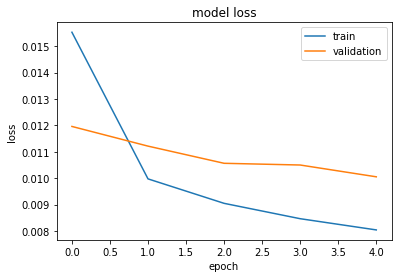

In [42]:
plot_train(hist)

In [43]:
preds = np.squeeze(model.predict(map_valid, 1024))

83/83 [==============================] - 1s 13ms/step


In [44]:
preds

array([0.8353323 , 0.85110456, 0.80356425, ..., 0.8666468 , 0.84213454,
       0.85868645], dtype=float32)

In [45]:
log_max_inv(preds)

array([ 7211.9067,  8528.953 ,  5144.3105, ..., 10061.876 ,  7752.949 ,
        9245.139 ], dtype=float32)

In [46]:
def get_metric(sales, sales_):
    return np.sqrt((((sales - sales_)/sales)**2).sum()/len(sales))

In [47]:
train_predictions = model.predict(map_train)

23747/23747 [==============================] - 85s 4ms/step


In [48]:
get_metric(log_max_inv(train_predictions).reshape(-1), y_train_orig)

0.09707558183465481

In [49]:
valid_predictions = model.predict(map_valid)

2639/2639 [==============================] - 9s 3ms/step


In [50]:
get_metric(log_max_inv(valid_predictions).reshape(-1), y_valid_orig)

0.15407750651346977

In [51]:
for v in contin_vars: joined_test.loc[joined_test[v].isnull(), v] = 0
for v in cat_vars: joined_test.loc[joined_test[v].isnull(), v] = ""

In [52]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined_test)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [53]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined_test)
contin_cols = len(contin_map_fit.features)
contin_cols

16

In [54]:
cat_map_fit.transform(joined_test)[0,:5], contin_map_fit.transform(joined_test)[0,:5]

(array([ 0, 16,  3,  1,  3]),
 array([-0.52716013, -1.38175178, -1.03510285,  0.08602054,  0.81816582]))

In [55]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

In [56]:
[len(o[1].classes_) for o in cat_map_fit.features]

[856, 31, 7, 2, 8, 23, 8, 8, 2, 3, 4, 1, 25, 4, 8, 19, 6, 6, 2, 2, 8, 8]

In [57]:
contin_map_test = contin_preproc(joined_test)

In [58]:
cat_map_test = cat_preproc(joined_test)

In [59]:
map_test = split_cols(cat_map_test) + [contin_map_test]

In [60]:
test_predictions = model.predict(map_test)

1284/1284 [==============================] - 5s 4ms/step


In [61]:
test_preds = log_max_inv(np.squeeze(test_predictions))

In [62]:
final = pd.DataFrame(data=test_preds,columns=['Sales'])
final.index.name = 'Id'
final.index += 1

In [63]:
final['Sales']

Id
1        4829.476562
2        5244.022461
3        7348.820312
4        8135.527832
5        4786.180176
            ...     
41084    3051.253418
41085    9065.535156
41086    7240.319824
41087    4892.401855
41088    6762.933105
Name: Sales, Length: 41088, dtype: float32

In [64]:
final.to_csv('sample_submission1.csv', sep=',', encoding='utf-8')